# Check FLOPS of SAN19 wrt different input size

In [1]:
import sys
import os

import torch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, os.path.abspath('..'))

from src.models.san import SAN, Bottleneck
from tools.complexity import (get_model_complexity_info,
                              is_supported_instance,
                              flops_to_string,
                              get_model_parameters_number)

In [2]:
def collect_flops(model, units='GMac', precision=3):
    """Wrapper to collect flops and number of parameters at each layer"""
    total_flops = model.compute_average_flops_cost()

    def accumulate_flops(self):
        if is_supported_instance(self):
            return self.__flops__ / model.__batch_counter__
        else:
            sum = 0
            for m in self.children():
                sum += m.accumulate_flops()
            return sum

    def flops_repr(self):
        accumulated_flops_cost = self.accumulate_flops()
        return ', '.join([flops_to_string(accumulated_flops_cost, units=units, precision=precision),
                          '{:.3%} MACs'.format(accumulated_flops_cost / total_flops),
                          self.original_extra_repr()])

    def add_extra_repr(m):
        m.accumulate_flops = accumulate_flops.__get__(m)
        flops_extra_repr = flops_repr.__get__(m)
        if m.extra_repr != flops_extra_repr:
            m.original_extra_repr = m.extra_repr
            m.extra_repr = flops_extra_repr
            assert m.extra_repr != m.original_extra_repr

    def del_extra_repr(m):
        if hasattr(m, 'original_extra_repr'):
            m.extra_repr = m.original_extra_repr
            del m.original_extra_repr
        if hasattr(m, 'accumulate_flops'):
            del m.accumulate_flops

    model.apply(add_extra_repr)
    # print(model, file=ost)

    # Retrieve flops and param at each layer and sub layer (2 levels)
    flops_dict, param_dict = {}, {}
    for i in model._modules.keys():
        item = model._modules[i]
        if isinstance(model._modules[i], torch.nn.modules.container.Sequential):
            for j in model._modules[i]._modules.keys():
                key = '{}-{}'.format(i, j)
                flops_dict[key] = item._modules[j].accumulate_flops()
                param_dict[key] = get_model_parameters_number(item._modules[j])
        else:
            flops_dict[i] = item.accumulate_flops()
            param_dict[i] = get_model_parameters_number(item)

    model.apply(del_extra_repr)
    return flops_dict, param_dict


def run_experiment(model, in_size=(3, 224, 224), verbose=True, as_strings=True):
    macs, params = get_model_complexity_info(model, in_size, as_strings=as_strings, print_per_layer_stat=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print()

    if verbose:
        print('{:<15} {:>12} {:>12} {:>12} {:>12}'.format(
            'Layer', 'Flops (GMac)', 'Param (M)', 'AccFlops', 'AccParam'))
        print('-'*67)
        flops_dict, param_dict = collect_flops(model)
        total_flops, total_param = 0, 0
        for k in flops_dict:
            total_flops += flops_dict[k]*1e-9
            total_param += param_dict[k]*1e-6
            print('{:<15} {:>12.5f} {:>12.5f} {:>12.2f} {:>12.2f}'.format(
                k, flops_dict[k]*1e-9, param_dict[k]*1e-6, total_flops, total_param))
    return macs

# Small experiment with resolution of 64, 112, and 224

In [3]:
# SAN 19 - pairwise
model = SAN(
    sa_type=0,
    block=Bottleneck,
    layers=[3, 3, 4, 6, 3],
    kernels=[3, 7, 7, 7, 7],
    num_classes=1000,
).cuda()
delattr(model, 'fc')

in_side_lst = [224, 112, 64]
for in_side in in_side_lst:
    print('side =', in_side)
    run_experiment(model, in_size=(3, in_side, in_side), verbose=False, as_strings=True)
    print('------------------------------------------------------------------')

side = 224
Computational complexity:       3.84 GMac
Number of parameters:           15.55 M 

------------------------------------------------------------------
side = 112
Computational complexity:       0.92 GMac
Number of parameters:           15.55 M 

------------------------------------------------------------------
side = 64
Computational complexity:       0.31 GMac
Number of parameters:           15.55 M 

------------------------------------------------------------------


# More experiments with resolution from 64 to 224

In [4]:
side_lst = []
flops_lst = []
for i in range(64, 224+1):
    print(i)
    flops = run_experiment(model, in_size=(3, i, i), verbose=False, as_strings=False)
    side_lst.append(i)
    flops_lst.append(flops)

64
Computational complexity:       313641192.0
Number of parameters:           15547156

65
Computational complexity:       313698984.0
Number of parameters:           15547156

66
Computational complexity:       314755812.0
Number of parameters:           15547156

67
Computational complexity:       314815396.0
Number of parameters:           15547156

68
Computational complexity:       323614122.0
Number of parameters:           15547156

69
Computational complexity:       323675498.0
Number of parameters:           15547156

70
Computational complexity:       324797334.0
Number of parameters:           15547156

71
Computational complexity:       324860502.0
Number of parameters:           15547156

72
Computational complexity:       354358504.0
Number of parameters:           15547156

73
Computational complexity:       354423464.0
Number of parameters:           15547156

74
Computational complexity:       355610308.0
Number of parameters:           15547156

75
Computational comp

Computational complexity:       1640895566.0
Number of parameters:           15547156

158
Computational complexity:       1643447578.0
Number of parameters:           15547156

159
Computational complexity:       1643589594.0
Number of parameters:           15547156

160
Computational complexity:       1960257450.0
Number of parameters:           15547156

161
Computational complexity:       1960401258.0
Number of parameters:           15547156

162
Computational complexity:       1963018278.0
Number of parameters:           15547156

163
Computational complexity:       1963163878.0
Number of parameters:           15547156

164
Computational complexity:       1984736460.0
Number of parameters:           15547156

165
Computational complexity:       1984883852.0
Number of parameters:           15547156

166
Computational complexity:       1987565880.0
Number of parameters:           15547156

167
Computational complexity:       1987715064.0
Number of parameters:           15547156

168

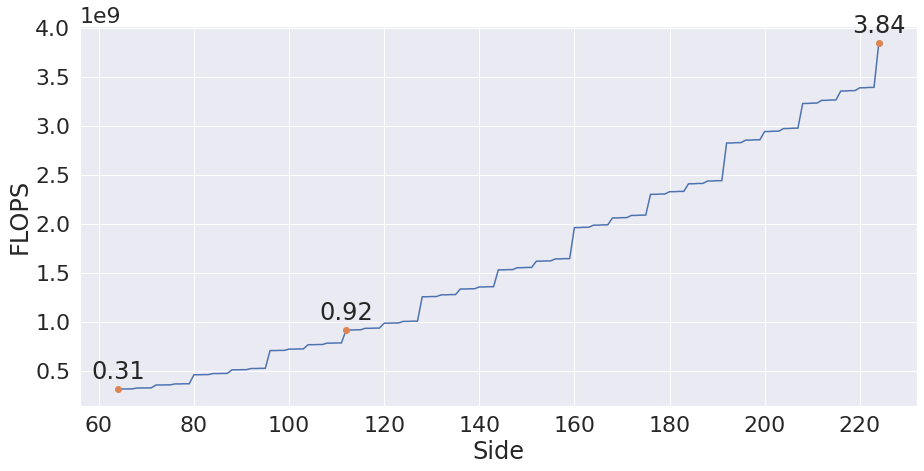

In [5]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(side_lst, flops_lst)
ax.set_xlabel('Side')
ax.set_ylabel('FLOPS')

ax.plot([side_lst[x-64] for x in [64, 112, 224]], [flops_lst[x-64] for x in [64, 112, 224]], 'o')
for side in [64, 112, 224]:
    idx = side - 64
    ax.annotate('{:.02f}'.format(flops_lst[idx] * 1e-9),
                (side_lst[idx], flops_lst[idx]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
               )

# plt.savefig('resolution_analysis.pdf')